In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# ! pip install sdv

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np

import common

In [5]:
data_set_path = "../temp_sets_100/"

# procedureevents_mv

## Data Process

In [6]:
procedureevents_mv_df = common.read_csv_no_rowid(data_set_path + "procedureevents_mv.csv")

In [7]:
procedureevents_mv_df.head()

,subject_id,hadm_id,icustay_id,starttime,endtime,itemid,value,valueuom,location,locationcategory,...,ordercategoryname,secondaryordercategoryname,ordercategorydescription,isopenbag,continueinnextdept,cancelreason,statusdescription,comments_editedby,comments_canceledby,comments_date
0,44346,140114,250021,2165-04-05 10:10:00,2165-04-07 22:00:00,224277,3590.0,min,R Antecube,Peripheral - old,...,Peripheral Lines,NaN,Task,1,0,0,FinishedRunning,NaN,NaN,NaN
1,44346,140114,250021,2165-04-05 10:21:00,2165-04-07 16:59:00,224275,3278.0,min,L Wrist,Peripheral - old,...,Peripheral Lines,NaN,Task,1,0,0,FinishedRunning,NaN,NaN,NaN
2,44346,140114,250021,2165-04-05 11:44:00,2165-04-05 11:45:00,225433,1.0,None,NaN,NaN,...,Procedures,NaN,Electrolytes,0,0,0,FinishedRunning,NaN,NaN,NaN
3,44346,140114,250021,2165-04-05 12:37:00,2165-04-05 12:38:00,225459,1.0,None,NaN,NaN,...,Imaging,NaN,Electrolytes,0,0,0,FinishedRunning,NaN,NaN,NaN
4,44346,140114,250021,2165-04-06 06:22:00,2165-04-06 06:23:00,225459,1.0,None,NaN,NaN,...,Imaging,NaN,Electrolytes,0,0,0,FinishedRunning,NaN,NaN,NaN


## Data Process

In [8]:
# Drop some null value
# procedureevents_mv_df.dropna(subset=['hadm_id', ], inplace=True, axis=0)

### Data preproces

In [9]:
# Drop some columns
procedureevents_mv_df.drop(['location', 'locationcategory', 'storetime', 'cgid', 'secondaryordercategoryname', 
    'continueinnextdept', 'cancelreason', 'comments_editedby', 'comments_canceledby', 'comments_date'], axis=1, inplace=True)

#### Deal with missing values

In [10]:
common.nan_count(procedureevents_mv_df)

Total columns: 14
Total rows: 628
--------------
subject_id                  0
hadm_id                     0
icustay_id                  0
starttime                   0
endtime                     0
itemid                      0
value                       0
valueuom                    0
orderid                     0
linkorderid                 0
ordercategoryname           0
ordercategorydescription    0
isopenbag                   0
statusdescription           0
dtype: int64


#### Set the column types

In [11]:
procedureevents_mv_df.dtypes

subject_id                    int64
hadm_id                       int64
icustay_id                    int64
starttime                    object
endtime                      object
itemid                        int64
value                       float64
valueuom                     object
orderid                       int64
linkorderid                   int64
ordercategoryname            object
ordercategorydescription     object
isopenbag                     int64
statusdescription            object
dtype: object

In [12]:
procedureevents_mv_df['starttime'] = pd.to_datetime(procedureevents_mv_df['starttime'])
procedureevents_mv_df['endtime'] = pd.to_datetime(procedureevents_mv_df['endtime'])

In [13]:
procedureevents_mv_df.dtypes

subject_id                           int64
hadm_id                              int64
icustay_id                           int64
starttime                   datetime64[ns]
endtime                     datetime64[ns]
itemid                               int64
value                              float64
valueuom                            object
orderid                              int64
linkorderid                          int64
ordercategoryname                   object
ordercategorydescription            object
isopenbag                            int64
statusdescription                   object
dtype: object

#### Process special data

In [14]:
invalid_index = procedureevents_mv_df.loc[(procedureevents_mv_df['starttime'] > procedureevents_mv_df['endtime']) == True].index
procedureevents_mv_df.drop(invalid_index, inplace=True, axis=0)

#### Process some special value

In [15]:
icustays_df = common.read_csv_no_rowid(data_set_path+"icustays.csv")

In [16]:
icu_intime_df = icustays_df.loc[:, ['icustay_id', 'intime']]
icu_intime_df['intime'] = pd.to_datetime(icu_intime_df['intime'])

In [17]:
procedureevents_mv_mid_df = pd.merge(left=procedureevents_mv_df, right=icu_intime_df, how='left', on=['icustay_id'])

In [18]:
procedureevents_mv_mid_df.dtypes

subject_id                           int64
hadm_id                              int64
icustay_id                           int64
starttime                   datetime64[ns]
endtime                     datetime64[ns]
itemid                               int64
value                              float64
valueuom                            object
orderid                              int64
linkorderid                          int64
ordercategoryname                   object
ordercategorydescription            object
isopenbag                            int64
statusdescription                   object
intime                      datetime64[ns]
dtype: object

In [19]:
procedureevents_mv_mid_df['endtime'] = procedureevents_mv_mid_df.apply(common.time_process, args=('starttime', 'endtime'), axis=1)
procedureevents_mv_mid_df['starttime'] = procedureevents_mv_mid_df.apply(common.time_process, args=('intime', 'starttime'), axis=1)

procedureevents_mv_mid_df['endtime'] = procedureevents_mv_mid_df['endtime'].astype(np.int64)
procedureevents_mv_mid_df['starttime'] = procedureevents_mv_mid_df['starttime'].astype(np.int64)

In [20]:
procedureevents_mv_mid_df.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'starttime', 'endtime', 'itemid',
       'value', 'valueuom', 'orderid', 'linkorderid', 'ordercategoryname',
       'ordercategorydescription', 'isopenbag', 'statusdescription', 'intime'],
      dtype='object')

In [21]:
procedureevents_mv_df = procedureevents_mv_mid_df.drop(['subject_id', 'hadm_id', 'icustay_id', 'intime'], axis=1)

---

## Build model

### Set constraints

In [22]:
procedureevents_mv_df.columns

Index(['starttime', 'endtime', 'itemid', 'value', 'valueuom', 'orderid',
       'linkorderid', 'ordercategoryname', 'ordercategorydescription',
       'isopenbag', 'statusdescription'],
      dtype='object')

In [23]:
from sdv.constraints import FixedCombinations

fixed_itemid_value_valueuom_constraint = FixedCombinations(
    column_names=['itemid', 'value', 'valueuom']
)

fixed_itemid_orderid_linkorderid_constraint = FixedCombinations(
    column_names=['orderid', 'linkorderid', 'ordercategoryname', 'ordercategorydescription']
)

In [24]:
constraints = [fixed_itemid_value_valueuom_constraint, fixed_itemid_orderid_linkorderid_constraint]

### Build model

In [25]:
train_data = procedureevents_mv_df

In [26]:
best_model = common.build_model(constraints=constraints, train_data=train_data)

Strat training ...
Tabular Preset


Sampling rows: 100%|██████████| 628/628 [00:00<00:00, 17860.69it/s]

Gaussian Copula



Sampling rows: 100%|██████████| 628/628 [00:00<00:00, 19252.02it/s]


CTGAN


Sampling rows: 100%|██████████| 628/628 [00:00<00:00, 9500.67it/s]


CopulaGAN


Sampling rows: 100%|██████████| 628/628 [00:00<00:00, 12210.27it/s]


TVAE


Sampling rows: 100%|██████████| 628/628 [00:00<00:00, 13404.08it/s]


Training finished!
Strat evaluating ...
Evaluating finished!
The best_model is tvae, evaluation score is 0.5668242697164019


In [27]:
model_save_path = data_set_path + "100_models/" + "procedureevents_mv_model.pkl"
common.save_model(best_model, model_save_path)

---

## Evaluate data

In [28]:
from sdv.evaluation import evaluate

In [29]:
date_load_path = data_set_path + "100_models/" + "procedureevents_mv_model.pkl"
model = common.load_model(date_load_path)

In [30]:
sample = model.sample(num_rows=len(train_data))

Sampling rows: 100%|██████████| 628/628 [00:00<00:00, 12130.14it/s]


In [31]:
evaluate(sample, train_data, metrics=['ContinuousKLDivergence'])

0.8487509759028443

In [32]:
evaluate(sample, train_data, metrics=['DiscreteKLDivergence'])

0.6488549551096637

In [33]:
evaluate(sample, train_data)

0.5592690132180533

<AxesSubplot:xlabel='itemid', ylabel='value'>

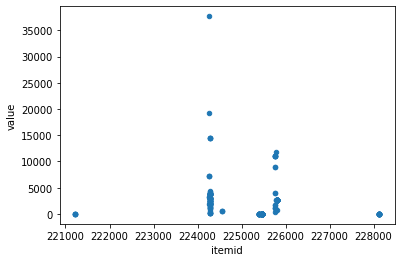

In [34]:
sample.sort_values('itemid').plot(x='itemid', y='value', kind='scatter')

<AxesSubplot:xlabel='itemid', ylabel='value'>

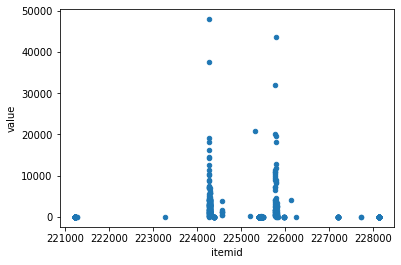

In [35]:
train_data.sort_values('itemid').plot(x='itemid', y='value', kind='scatter')

<AxesSubplot:>

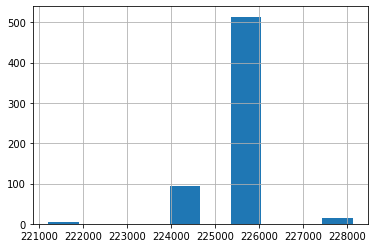

In [36]:
sample.sort_values('itemid')['itemid'].hist()

<AxesSubplot:>

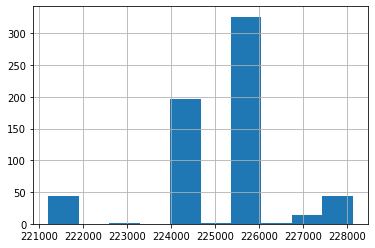

In [37]:
train_data.sort_values('itemid')['itemid'].hist()